This notebook implements Assignment 2 of course on Trustworthy Machine Learning.

In [ ]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import requests
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToPILImage
import torch.nn.functional as F

In [ ]:
import requests
import torch
import torch.nn as nn
import onnxruntime as ort
import numpy as np
import json
import io
import sys
import base64
from torch.utils.data import Dataset
from typing import Tuple
import pickle
import os

cwd = os.getcwd()
print('cwd: ', cwd)

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

cwd:  /content


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading dataset and applying transforms

In [5]:
data: TaskDataset = torch.load("/content/ModelStealingPub.pt")

In [6]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

In [7]:
transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [8]:
data.transform = transform

Applying two transformations to the original dataset - Random Horizontal Flip and Grayscale transformation

In [9]:
transform_augmented1 = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.RandomHorizontalFlip(p=1.0)
    ]
)

In [10]:
transform_augmented2 = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Grayscale(num_output_channels=3)
    ]
)

Creating augmented datasets from the training dataset

In [11]:
class HorizontalFlipDataset(TaskDataset):
    def __init__(self, original_dataset, transform=None):
        super().__init__(transform=transform_augmented1)
        self.ids = original_dataset.ids
        self.imgs = original_dataset.imgs
        self.labels = original_dataset.labels

class GrayscaleDataset(TaskDataset):
    def __init__(self, original_dataset, transform=None):
        super().__init__(transform=transform_augmented2)
        self.ids = original_dataset.ids
        self.imgs = original_dataset.imgs
        self.labels = original_dataset.labels

In [12]:
horizontal_flip_dataset = HorizontalFlipDataset(data, transform_augmented1)
grayscale_dataset = GrayscaleDataset(data, transform_augmented2)

In [13]:
flip = transforms.RandomHorizontalFlip(p=1.0)

def flip_images(orig_images):
    return [flip(img) for img in orig_images]

orig_images = [horizontal_flip_dataset.imgs[idx] for idx in range(len(data))]

horizontal_flip_dataset.imgs = flip_images(orig_images)

In [14]:
convert_to_grayscale = transforms.Grayscale(num_output_channels=3)

def convert_to_grayscale_images(orig_images):
    return [convert_to_grayscale(img) for img in orig_images]

orig_images1 = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]

# Convert the images to tensors
grayscale_dataset.imgs = convert_to_grayscale_images(orig_images1)

In [15]:
to_tensor = transforms.ToTensor()

def convert_images_to_tensors(pil_images):
    return [to_tensor(img) for img in pil_images]

pil_images = [data.imgs[idx] for idx in range(len(data))]
pil_images_flip = [horizontal_flip_dataset.imgs[idx] for idx in range(len(horizontal_flip_dataset))]
pil_images_grayscale = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]

# Convert the images to tensors
data.imgs = convert_images_to_tensors(pil_images)
horizontal_flip_dataset.imgs = convert_images_to_tensors(pil_images_flip)
grayscale_dataset.imgs = convert_images_to_tensors(pil_images_grayscale)

Verification that the transformations have been correctly applied to the original dataset

In [16]:
def show_images(images, n=5):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = images[i].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

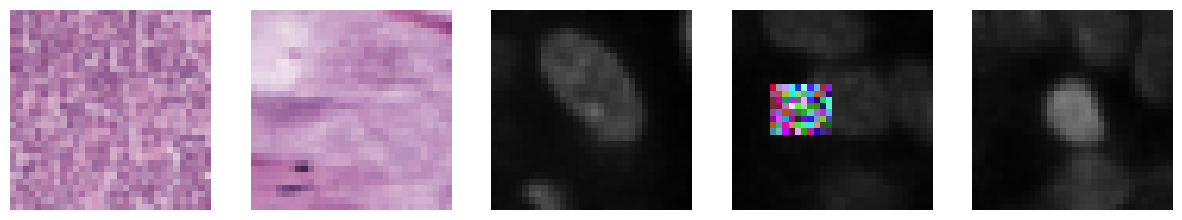

In [17]:
show_images(data.imgs)

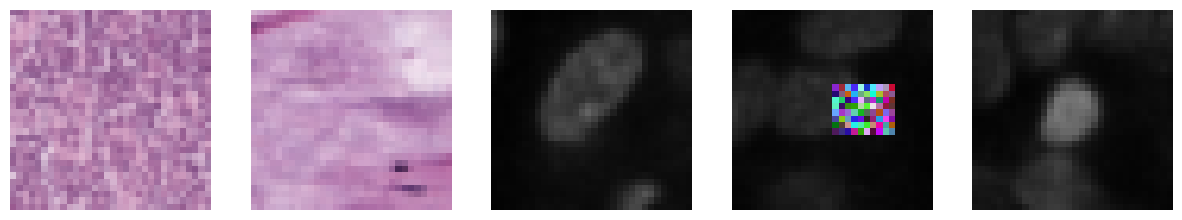

In [18]:
show_images(horizontal_flip_dataset.imgs)

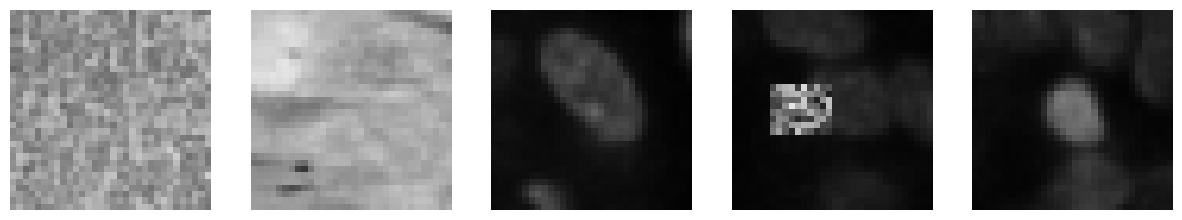

In [19]:
show_images(grayscale_dataset.imgs)

In [ ]:
### REQUESTING NEW API ###
TOKEN = "92593601" # to be changed according to your token (given to you for the assignments)

response = requests.get("http://34.71.138.79:9090" + "/stealing_launch", headers={"token": TOKEN})
answer = response.json()

print(answer)  # {"seed": "SEED", "port": PORT}
if 'detail' in answer:
    sys.exit(1)

# save the values
SEED = str(answer['seed'])
PORT = str(answer['port'])

# SEED = "1868949"
# PORT = "9002"

{'seed': 29268610, 'port': '9060'}


Querying the API with the augmented dataset with horizontal flipping transformation

In [20]:
to_pil = ToPILImage()
pil_images = [to_pil(img_tensor) for img_tensor in horizontal_flip_dataset.imgs]

selected_pil_images = [pil_images[idx] for idx in np.random.permutation(1000)]

In [ ]:
### QUERYING THE API ###

def model_stealing(images, port):
    endpoint = "/query"
    url = f"http://34.71.138.79:{port}" + endpoint
    image_data = []
    for img in images:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)

    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": "92593601"})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )

out = model_stealing(selected_pil_images, port="9060")

In [ ]:
# 1000 representations in a list
print(len(out))

# representation 1
print(len(out[0]))

# first element in the representation
print(out[0][0])

1000
1024
-1.9903837442398071 -2.7293248176574707


In [ ]:
# Store the output in a file.
# Be careful to store all the outputs from the API since the number of queries is limited.
with open('new36.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Restore the output from the file.
with open('new36.pickle', 'rb') as handle:
    out = pickle.load(handle)

print(len(out))

1000


Defining the stolen model's architecture and an instance of the Stolen Encoder

In [21]:
class StolenEncoder(nn.Module):
    def __init__(self, input_channels, input_height, input_width):
        super(StolenEncoder, self).__init__()
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * (input_height // 4) * (input_width // 4), 1024)
        )

    def forward(self, x):
        return self.encoder(x)

In [22]:
input_channels = 3
input_height = 32
input_width = 32

model = StolenEncoder(input_channels, input_height, input_width).to(device)

In [23]:
# Load victim representations from the stored representation files
victim_representations = []

for i in range(1, 16):
    with open(f'/content/new{i}.pickle', 'rb') as handle:
        victim_representations.extend(pickle.load(handle))

In [24]:
with open('combined_vrepresen15.pickle', 'wb') as handle:
    pickle.dump(victim_representations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
victim_representations = torch.tensor(victim_representations).to(device)

In [26]:
to_pil = ToPILImage()

def convert_to_pil(grayscale_image_tensors):
    return [to_pil(img) for img in grayscale_image_tensors]

grayscale_image_tensors = [grayscale_dataset.imgs[idx] for idx in range(len(grayscale_dataset))]

grayscale_dataset.imgs = convert_to_pil(grayscale_image_tensors)

Training the stolen encoder and minimize the loss between stolen and victim encoder's representations

In [27]:
flip_data_loader = DataLoader(horizontal_flip_dataset, batch_size=64, shuffle=False)
grayscale_data_loader = DataLoader(grayscale_dataset, batch_size=64, shuffle=False)

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

epochs = 30
for epoch in range(epochs):
    for i, (batch_ids, batch_images, batch_labels) in enumerate(grayscale_data_loader):
        batch_images = [(img.repeat(3, 1, 1) if img.size(0) == 1 else img) for img in batch_images]
        batch_images = torch.stack(batch_images).to(device)

        batch_size = batch_images.size(0)
        start_idx = i * grayscale_data_loader.batch_size
        end_idx = start_idx + batch_size

        # to handle the mismatch of the length of the stolen and victim encoder's representations
        if end_idx > len(victim_representations):
            end_idx = len(victim_representations)
            batch_victim_reps = victim_representations[start_idx:end_idx]
            batch_images = batch_images[:end_idx-start_idx]
        else:
            batch_victim_reps = victim_representations[start_idx:end_idx]

        if len(batch_victim_reps) != batch_size:
            print(f"Skipped batch {i+1} because of mismatch between images ({batch_size}) and victim representations ({len(batch_victim_reps)}).")
            continue

        stolen_reps = model(batch_images)
        loss = criterion(stolen_reps, batch_victim_reps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}], Loss: {loss.item():.4f}")

torch.save(model, 'stolen_encoder.pth')

Streaming output truncated to the last 5000 lines.
Epoch [6/30], Batch [101], Loss: 0.1280
Epoch [6/30], Batch [102], Loss: 0.1393
Epoch [6/30], Batch [103], Loss: 0.1339
Epoch [6/30], Batch [104], Loss: 0.1244
Epoch [6/30], Batch [105], Loss: 0.1761
Epoch [6/30], Batch [106], Loss: 0.1351
Epoch [6/30], Batch [107], Loss: 0.1249
Epoch [6/30], Batch [108], Loss: 0.1346
Epoch [6/30], Batch [109], Loss: 0.1627
Epoch [6/30], Batch [110], Loss: 0.1650
Epoch [6/30], Batch [111], Loss: 0.1175
Epoch [6/30], Batch [112], Loss: 0.1469
Epoch [6/30], Batch [113], Loss: 0.1532
Epoch [6/30], Batch [114], Loss: 0.1392
Epoch [6/30], Batch [115], Loss: 0.1227
Epoch [6/30], Batch [116], Loss: 0.1626
Epoch [6/30], Batch [117], Loss: 0.1682
Epoch [6/30], Batch [118], Loss: 0.1273
Epoch [6/30], Batch [119], Loss: 0.1660
Epoch [6/30], Batch [120], Loss: 0.1350
Epoch [6/30], Batch [121], Loss: 0.1330
Epoch [6/30], Batch [122], Loss: 0.1553
Epoch [6/30], Batch [123], Loss: 0.1684
Epoch [6/30], Batch [124], Lo

In [29]:
#### SUBMISSION ####

# exporting the stolen encoder to the onnx format

path = '/content/dummy_submission1.onnx'

torch.onnx.export(
    model,
    torch.randn(1, 3, 32, 32).to(device),
    path,
    export_params=True,
    input_names=["x"],
)

#### Tests ####

# (these are being ran on the eval endpoint for every submission)
with open(path, "rb") as f:
    model = f.read()
    try:
        stolen_model = ort.InferenceSession(model)
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")
    try:
        out = stolen_model.run(
            None, {"x": np.random.randn(1, 3, 32, 32).astype(np.float32)}
        )[0][0]
    except Exception as e:
        raise Exception(f"Some issue with the input, {e=}")
    assert out.shape == (1024,), "Invalid output shape"

# Send the model to the server
response = requests.post("http://34.71.138.79:9090/stealing", files={"file": open(path, "rb")}, headers={"token": "92593601", "seed": "29268610"})
print(response.json())

{'L2': 11.320414543151855}
